In [1]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numba import jit
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import root_scalar, curve_fit
from pynndescent import NNDescent
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA

In [2]:
def exp_k(dists, sigma):
    return np.exp(- (dists - dists[0]) / sigma).sum()

In [3]:
def find_sigma(d, k, lower_bound=1e-6, upper_bound=1e6):
    return root_scalar(
        lambda s: exp_k(d, s) - np.log2(k),
        bracket=(lower_bound, upper_bound)
    ).root

In [18]:
def p_ij_sym(x, k, verbose=False):
    num_pts = x.shape[0]
    if verbose:
        print('Indexing')
    index = NNDescent(x)
    neighbors = np.empty((num_pts, k), dtype=np.int)
    p_ij = np.empty((num_pts, k))
    for i, xi in enumerate(x):
        if verbose:
            print('Calculating probabilities: {cur}/{tot}'.format(
                cur=i+1, tot=num_pts), end='\r')
        nn, dists = index.query([xi], k+1)
        sigma = find_sigma(dists[0, 1:], k)
        neighbors[i] = nn[0, 1:]
        p_ij[i] = np.exp(- (dists[0, 1:] - dists[0, 1]) / sigma)
    row_indices = np.repeat(np.arange(num_pts), k)
    p = csr_matrix((p_ij.ravel(), (row_indices, neighbors.ravel())))
    return p + p.transpose() - (p.multiply(p.transpose()))

In [5]:
def pdiff(x):
    batch_size = x.shape[0] 
    expanded = x.unsqueeze(1)
    tiled = torch.repeat_interleave(expanded, batch_size, dim=1)
    diffs = tiled - tiled.transpose(0, 1)  
    return diffs

In [6]:
def find_ab_params(spread, min_dist):
    """Fit a, b params for the differentiable curve used in lower
    dimensional fuzzy simplicial complex construction. We want the
    smooth curve (from a pre-defined family with simple gradient) that
    best matches an offset exponential decay.
    """

    def curve(x, a, b):
        return 1.0 / (1.0 + a * x ** (2 * b))

    xv = np.linspace(0, spread * 3, 300)
    yv = np.zeros(xv.shape)
    yv[xv < min_dist] = 1.0
    yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist) / spread)
    params, covar = curve_fit(curve, xv, yv)
    return params[0], params[1]

In [7]:
def dist_mat_squared(x):
    batch_size = x.shape[0] 
    expanded = x.unsqueeze(1)
    tiled = torch.repeat_interleave(expanded, batch_size, dim=1)
    diffs = tiled - tiled.transpose(0, 1)
    sum_act = torch.sum(torch.pow(diffs,2), axis=2)    
    return sum_act

In [447]:
def q_ij(x, a, b):
    dists = dist_mat_squared(x)
    dists.fill_diagonal_(1.)
    q = torch.pow(1 + a * torch.pow(dists, b), -1)
    q.fill_diagonal_(0.)
    return q

In [9]:
def submatrix(m, indices):
    dim = len(indices)
    indices = np.array(np.meshgrid(indices, indices)).T.reshape(-1,2).T
    return torch.tensor(m[indices[0], indices[1]].reshape(dim, dim))

In [431]:
def umap_loss(p, q, eps=1.0e-7):
    eps = torch.tensor(eps, dtype=p.dtype)
    l_a = torch.mul(p, torch.log(p + eps) - torch.log(q + eps))
    l_b = torch.mul(1 - p, torch.log(1 - p + eps) - torch.log(1 - q + eps))
    loss_mat = l_a #+ l_b
    loss_mat.fill_diagonal_(0.)
    return torch.sum(loss_mat)

In [448]:
class Parametric_UMAP(nn.Module):
    
    def __init__(self, input_dim, output_dim, knn, min_dist,
                 spread=1.0,
                 hidden_layer_dims=None,
                 seed=None,
                 use_cuda=False):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.knn = knn
        self.min_dist = min_dist
        self.spread = spread
        
        self.a, self.b = find_ab_params(self.spread, self.min_dist)
        
        self.use_cuda = use_cuda
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        # If no layers provided, use the same architecture as van der maaten 2009 paper
        if hidden_layer_dims is None:
            hidden_layer_dims = [500, 500, 2000]
        
        self.layers = nn.ModuleList()
        
        cur_dim = input_dim
        for hdim in hidden_layer_dims:
            self.layers.append(nn.Linear(cur_dim, hdim))
            cur_dim = hdim
        self.layers.append(nn.Linear(cur_dim, output_dim))
        
        if self.use_cuda:
            self.cuda()
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            # x = torch.sigmoid(layer(x))
            x = F.softplus(layer(x))
        out = self.layers[-1](x)
        return out
    
    def pretrain(self, training_data,
            epochs=10,
            verbose=False,
            batch_size=500,
            learning_rate=0.01):
        if verbose:
            print('Calculating PCA')
        pca = torch.tensor(PCA(n_components=2).fit_transform(training_data), dtype=training_data.dtype)
        
        dataset = torch.utils.data.TensorDataset(training_data, pca)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        
        if verbose:
            print('{time}: Beginning pretraining for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, targets = data
                    
                if self.use_cuda:
                    features = features.cuda()
                    targets = targets.cuda()
                    
                optim.zero_grad()
                
                loss = criterion(self(features), targets)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished pretraining'.format(
                time=datetime.datetime.now()))
        
    def fit(self, training_data,
            p_ij=None,
            pretrain=False,
            epochs=10,
            verbose=False,
            optimizer=torch.optim.Adam,
            batch_size=500,
            learning_rate=0.01):
        
        assert training_data.shape[1] == self.input_dim, "Input training data must be same shape as training `num_inputs`"
        
        self.p_ij = p_ij
        self._epochs = epochs
        
        if pretrain:
            self.pretrain(training_data, epochs=5, verbose=verbose, batch_size=batch_size)
            
        if self.p_ij is None:
            self.p_ij = p_ij_sym(training_data.numpy(), self.knn, verbose=verbose)
            
        dataset = torch.utils.data.TensorDataset(training_data, torch.arange(training_data.shape[0]))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = optimizer(self.parameters(), lr=learning_rate)
        
        if verbose:
            print('{time}: Beginning training for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, indices = data
                
                p = submatrix(self.p_ij, indices.numpy())
                    
                if self.use_cuda:
                    features = features.cuda()
                    p = p.cuda()
                    
                optim.zero_grad()
                
                q = q_ij(self(features), self.a, self.b)
                loss = umap_loss(p, q)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch+1,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished training'.format(
                time=datetime.datetime.now()))
            
    def test(self, training_data,
            p_ij=None,
            optimizer=torch.optim.Adam,
            batch_size=500,
            learning_rate=0.01):
        
        assert training_data.shape[1] == self.input_dim, "Input training data must be same shape as training `num_inputs`"
        
        self.p_ij = p_ij
            
        if self.p_ij is None:
            self.p_ij = p_ij_sym(training_data.numpy(), self.knn, verbose=True)
            
        dataset = torch.utils.data.TensorDataset(training_data, torch.arange(training_data.shape[0]))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = optimizer(self.parameters(), lr=learning_rate)
        
        for epoch in range(5):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, indices = data
                
                p = submatrix(self.p_ij, indices.numpy())
                    
                if self.use_cuda:
                    features = features.cuda()
                    p = p.cuda()
                    
                optim.zero_grad()
                
                q = q_ij(self(features), self.a, self.b)
                loss = umap_loss(p, q)
                
                return self(features), p, q, loss
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()

-----------------------

In [13]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [14]:
mnist = MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

In [15]:
testdata = mnist.data.reshape(-1, 28*28) / 255.

In [454]:
foo = Parametric_UMAP(28*28, 2, 100, 0.01, use_cuda=True, hidden_layer_dims=[300,100])

In [428]:
p_precalc = foo.p_ij

In [455]:
foo.fit(testdata[:20000], p_ij=p_precalc, batch_size=500, epochs=20, learning_rate=0.1, pretrain=False, verbose=True)

2020-01-10 14:35:20.748118: Beginning training for 20 epochs
2020-01-10 14:35:22.788188: Loss after epoch 1: nan
2020-01-10 14:35:24.746000: Loss after epoch 2: nan
2020-01-10 14:35:26.683360: Loss after epoch 3: nan
2020-01-10 14:35:28.674717: Loss after epoch 4: nan
2020-01-10 14:35:30.722240: Loss after epoch 5: nan


KeyboardInterrupt: 

In [411]:
bar = foo(testdata[:10000].cuda()).cpu().detach().numpy()

In [412]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

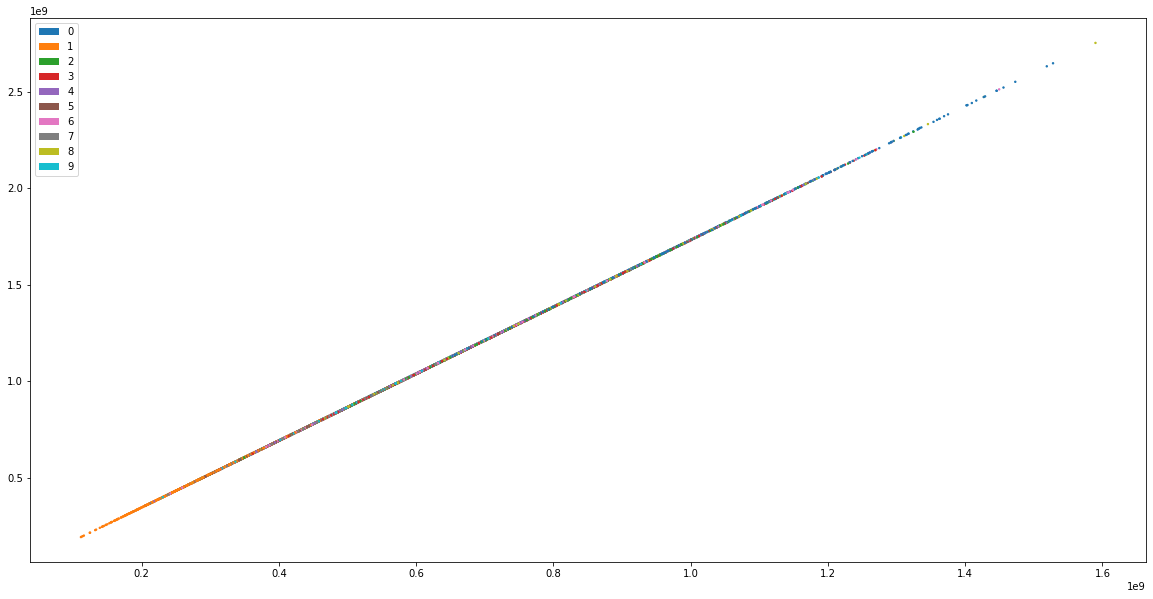

In [413]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[:10000]]
ax.scatter(bar[:,0],bar[:,1],c=colors, s=2)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [450]:
foof, foop, fooq, fool = foo.test(testdata[:20000], p_ij=p_precalc, batch_size=500, learning_rate=0.1)

In [453]:
foop.min()

tensor(0., device='cuda:0', dtype=torch.float64)

In [415]:
a = foop.detach().cpu()

In [416]:
a

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [417]:
b = foof.clone().detach().cpu().requires_grad_(True)

In [418]:
c = q_ij(b, 1.93, 0.79)

In [419]:
c

tensor([[0.0000e+00, 4.0607e+14, 9.9499e+13,  ..., 3.7544e+14, 5.4864e+13,
         2.3342e+14],
        [4.0607e+14, 0.0000e+00, 1.7613e+14,  ..., 3.3955e+12, 6.0104e+14,
         5.9205e+13],
        [9.9499e+13, 1.7613e+14, 0.0000e+00,  ..., 1.5382e+14, 2.2714e+14,
         5.8619e+13],
        ...,
        [3.7544e+14, 3.3955e+12, 1.5382e+14,  ..., 0.0000e+00, 5.6557e+14,
         4.4631e+13],
        [5.4864e+13, 6.0104e+14, 2.2714e+14,  ..., 5.6557e+14, 0.0000e+00,
         3.9718e+14],
        [2.3342e+14, 5.9205e+13, 5.8619e+13,  ..., 4.4631e+13, 3.9718e+14,
         0.0000e+00]], grad_fn=<CopySlices>)

In [425]:
(a/c).fill_diagonal_(0.).min()

tensor(0., dtype=torch.float64, grad_fn=<MinBackward1>)

In [407]:
b.grad

tensor([[ 6.6059e-02, -3.3072e-02],
        [-2.2798e-02,  1.3876e-02],
        [ 1.2777e-02,  1.8653e-03],
        [ 8.3001e-02,  1.0389e-01],
        [ 1.8398e-02, -7.9187e-03],
        [ 3.5960e-01,  3.0368e-02],
        [-1.6001e-01,  4.5607e-02],
        [-1.5123e-02,  4.9672e-02],
        [-1.7346e-01, -9.0581e-02],
        [-2.7534e-02, -1.5369e-01],
        [-1.3466e-02,  3.7864e-04],
        [ 8.0030e-03,  7.8491e-03],
        [-1.0292e-02, -3.5184e-02],
        [-9.4598e-05, -4.3678e-03],
        [-4.3323e-02,  9.5292e-03],
        [-1.0957e-01, -3.2264e-02],
        [-1.5169e-03, -8.0444e-03],
        [-1.5505e-01,  5.6354e-02],
        [ 7.4250e-02, -5.4863e-02],
        [ 1.8383e-02, -4.2418e-02],
        [ 5.4436e-03,  3.4749e-02],
        [ 1.5965e-02,  1.1012e-02],
        [-2.0360e-01,  1.6879e-01],
        [ 0.0000e+00,  0.0000e+00],
        [ 5.1412e-02, -1.1132e-01],
        [-8.7340e-02, -2.1304e-01],
        [ 1.6665e-03,  9.3597e-03],
        [ 0.0000e+00,  0.000

In [384]:
a = torch.tensor([[0.5, 0.6], [0.7, 0.3]])
b = torch.tensor([[0.1, 0.2], [0.4, 0.3]], requires_grad=True)
c = q_ij(b, 1.93, 0.79)

In [386]:
umap_loss(a, c).backward()

In [387]:
b.grad

tensor([[ 1.4690,  0.4897],
        [-1.4690, -0.4897]])